**This jupyter notebook demonstrates how to:**

1. Create a multivariate dataset using different data sets


In [0]:
#install libs that are not found at google colab by default
!pip install google

**Mount google drive to access files**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#Important defines:
#total number of lift stations
NUMBER_OF_LIFT_STATIONS = 30 

#number of pumps per lift stations
PUMPS_PER_LIFT_STATION  = [2,2,3,3,3,1,2,3,2,2,3,3,2,2,2,
                           2,3,2,2,2,2,2,2,2,2,2,2,2,2,2]

#google drive folder where datasets are stored
DATASETS_DIR = r'/content/gdrive/My Drive/datasets/'                         


In [0]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

**Analysis with lift stations register**

This data frame contains characteristics and specifications about sewage lift stations 

In [0]:
lift_station_register = pd.read_csv(DATASETS_DIR + r'cadastro_elevatorias.csv')
lift_station_register['nivel_max'] = lift_station_register['nivel_max'].str.replace(',', '.').astype(float)
lift_station_register['corrente1_max'] = lift_station_register['corrente1_max'].replace(',', '.').astype(float)
lift_station_register['corrente2_max'] = lift_station_register['corrente2_max'].replace(',', '.').astype(float)
lift_station_register['corrente3_max'] = lift_station_register['corrente3_max'].replace(',', '.').astype(float)




**Weather stations data**

Files where downloaded from http://www.inmet.gov.br/portal/index.php?r=bdmep/bdmep

Weather data are related to Sewage Lift Stations events because because part of the rainwater is improperly connected to the sewer network.

This dataset is composed by data from 9 weather stations wich are located in Belo Horizonte region. They are near sewage lift stations analysed at this master degree work.

Each weather station file contains daily precipitation between January 1, 2010 and December 31, 2018.


In [0]:
#load weather stations register containing ids from all weather stations
weather_stations = pd.read_csv(DATASETS_DIR + r'cadastro_estacoes.csv')

#load 9 weather stations datasets
weather_stations_data_list = []
for i,row in weather_stations.iterrows():
    #load the dataset from each weather station 
    #files names uses the id from each weather station
    weather_station_data = pd.read_csv(DATASETS_DIR + r'estacao_{0}.csv'.format(row['id']),delimiter=';')
    #set the datetime index
    weather_station_data['datahora'] = pd.to_datetime(weather_station_data['Data'],format='%d/%m/%Y')
    weather_station_data.index = pd.to_datetime(weather_station_data['datahora'])
    #change the precipitation column name preparing for concatenation
    new_column_name = f"WeatherStation_{row['id']}"
    weather_station_data = weather_station_data.rename(columns = {'Precipitacao':new_column_name})
    #append each weather station dataset to a list for letter concatenation
    weather_stations_data_list.append(weather_station_data[['datahora',new_column_name]])

#contatenate weather station datasets    
weather_stations_datas = pd.concat(weather_stations_data_list, axis=1)
weather_stations_datas = weather_stations_datas.drop(columns=['datahora',])
#fill values na with 0
weather_stations_datas = weather_stations_datas.fillna(0)

**Alarms and events data analysis and relationship with others datasets**




In [0]:
#some sewage lift station were deactivated after a specific date 
#the dict below helps to get correct operation interval
lifting_operation_intervals = {}
lifting_operation_intervals[3] = {'ini':pd.to_datetime(datetime.date(2011,1,1)) ,
                            'fim':pd.to_datetime(datetime.date(2013,4,8))}
lifting_operation_intervals[4] = {'ini':pd.to_datetime(datetime.date(2011,1,1)) ,
                            'fim':pd.to_datetime(datetime.date(2013,3,21))}
lifting_operation_intervals[5] = {'ini':pd.to_datetime(datetime.date(2011,1,1)) ,
                            'fim':pd.to_datetime(datetime.date(2013,3,28))}
lifting_operation_intervals[6] = {'ini':pd.to_datetime(datetime.date(2011,1,1)) ,
                            'fim':pd.to_datetime(datetime.date(2012,7,4))}
lifting_operation_intervals[7] = {'ini':pd.to_datetime(datetime.date(2011,1,1)) ,
                            'fim':pd.to_datetime(datetime.date(2016,11,8))}
lifting_operation_intervals[18] = {'ini':pd.to_datetime(datetime.date(2011,1,1)) ,
                             'fim':pd.to_datetime(datetime.date(2017,8,30))}
lifting_operation_intervals[24] = {'ini':pd.to_datetime(datetime.date(2011,1,1)) ,
                             'fim':pd.to_datetime(datetime.date(2016,11,27))}
lifting_operation_intervals[26] = {'ini':pd.to_datetime(datetime.date(2011,1,1)) ,
                             'fim':pd.to_datetime(datetime.date(2017,6,17))}
lifting_operation_intervals[27] = {'ini':pd.to_datetime(datetime.date(2011,1,1)) ,
                             'fim':pd.to_datetime(datetime.date(2016,12,8))}

**The function bellow helps to access alarm events with a generic content**

The function returns alarm and event data removing specific tags related to sewage lift stations.

In [0]:
def get_alarm_data(lift_station_index):
    """Function to return alarm data.

    Get alarms and events from dataset changing names and messages to 
    standardize the dataframe result.

    This function needs two global variables already declared: 
        lift_station_register: a dataframe containing information and 
          specifications from lift stations
        lifting_operation_intervals: a dictionary containing operating intervals 
          for sewage pumping stations

    Args:
        lift_station_index (int): index from the sewage lift station.

    Returns:
        dataframe: alarms dataframe with

    """
    #read alarm files
    alarms_file = DATASETS_DIR + r'alarms_utr_{:>02}w.csv'.format(lift_station_index)

    #verify if lift station has a operation interval to use just data 
    #during its operation period.
    try:
        start = lifting_operation_intervals[lift_station_index]['ini']
        end   = lifting_operation_intervals[lift_station_index]['fim']
        print(f'{lift_station_register.iloc[lift_station_index - 1].nome}:{ini} a {fim}')
    except:
        start = pd.to_datetime(datetime.date(2011,1,1))
        end   = pd.to_datetime(datetime.date(2018,7,31))
        pass    
    
    alarms = None
    first = True
    #read file with chunks to avoid Memory error
    reader = pd.read_csv(alarms_file, chunksize=50000)
    for chunk in reader:
        temp_regs = chunk
        temp_regs['INTIME_']  = pd.to_datetime(temp_regs['INTIME_'])
        temp_regs['OUTTIME_'] = pd.to_datetime(temp_regs['OUTTIME_'])    

        #create the dataframe at the first chunk and append later 
        if first:
            alarms = temp_regs
            first = False
        else:
            alarms = alarms.append(temp_regs)

    #filter data between end and start dates
    alarms = alarms[(alarms.INTIME_ >= start) & (alarms.INTIME_ <= end)] 
    #create index for datetime
    alarms.index = pd.to_datetime(alarms['INTIME_'])

    #set tag name for sewage level signal
    tag_level      = f'LI01-{lift_station_index}'

    #replaces tags and values ​​by generic content to facilitate
    #treatment of data
    for pump_index in range(1,4):
        tag_pump          = 'B{:>02}-{}'.format(pump_index,lift_station_index)
        new_tag_pump      = f'pump{pump_index}'
        tag_lift_station  = 'UTR_{:>02}'.format(lift_station_index)
        tag_eletric       = 'MGE{:>02}-{}'.format(pump_index,lift_station_index)
        new_tag_eletric   = f'eletrica_bomba{pump_index}'

        #change alarms messages with generic contents
        alarms.loc[alarms.TAG == tag_pump,    'TAG']  = new_tag_pump
        alarms.loc[alarms.TAG == tag_lift_station,      'TAG']  = 'lift_station'
        alarms.loc[alarms.TAG == tag_level,    'TAG']  = 'level'
        alarms.loc[alarms.TAG == tag_eletric, 'TAG']  = new_tag_eletric

        for fase in ['R', 'S', 'T', 'RS', 'RT', 'ST']:
          messages = ['Corrente Baixa fase {} - Normalizado'.format(fase),
                      'Corrente Baixa fase {}'.format(fase),
                      'Corrente Alta fase {} - Normalizado'.format(fase),
                      'Corrente Alta fase {}'.format(fase),
                      'Tensão {} Alta - Normalizado'.format(fase),
                      'Tensão {} Alta'.format(fase),
                      'Tensão {} Baixa - Normalizado'.format(fase),
                      'Tensão {} Baixa'.format(fase),]
          for message in messages:
            new_message = message.replace(' {}'.format(fase),'')
            alarms.loc[alarms.MESSAGE == message, 'MESSAGE']  = new_message


    return alarms

**The function bellow helps to access instruments data with a generic content**

The function returns instrument data (current for pump, level and timestamp) removing specific tags related to sewage lift stations. 

In [0]:
def get_instrument_data(lift_station_index):
    """Function to return instrument data.

    Get alarms and events from dataset changing names and messages to 
    standardize the dataframe result.

    This function needs two global variables already declared: 
        lift_station_register: a dataframe containing information and 
          specifications from lift stations
        lifting_operation_intervals: a dictionary containing operating intervals 
          for sewage pumping stations

    Args:
        lift_station_index (int): index from the sewage lift station.

    Returns:
        dataframe: instrument dataframe level and pump current values

    """

    #verify if lift station has a operation interval to use just data 
    #during its operation period.
    try:
        start = lifting_operation_intervals[lift_station_index]['ini']
        end   = lifting_operation_intervals[lift_station_index]['fim']
        print(f'{lift_station_register.iloc[lift_station_index - 1].nome}:{ini} a {fim}')
    except:
        start = pd.to_datetime(datetime.date(2011,1,1))
        end   = pd.to_datetime(datetime.date(2018,7,31))
        pass

    #read dataframe from file 
    data_file   = DATASETS_DIR + r'tab_inst_utr_{:>02}.csv'.format(lift_station_index)  
    instrument_data   = pd.read_csv(data_file)  
    instrument_data['TIMESTAMP'] = pd.to_datetime(instrument_data['TIMESTAMP'])
    instrument_data = instrument_data.sort_values(by=['TIMESTAMP'])
    instrument_data = instrument_data[(instrument_data.TIMESTAMP >= start) & 
                                      (instrument_data.TIMESTAMP <= end)]
    instrument_data.index = pd.to_datetime(instrument_data['TIMESTAMP'])

    #rename level column name
    column_level_name = 'LI01_{}'.format(lift_station_index)
    instrument_data = instrument_data.rename(columns={column_level_name: 'level',})


    #get limits for level signal
    limits = {'max':3*lift_station_register.iloc[lift_station_index - 1]['nivel_max'],
              'min':0.0}    
    
    #cleaning level value errors
    #if less than 0, starts with 0
    instrument_data.loc[instrument_data.level < 0, 'level'] = 0.0
    
    #set invalid level value at a column
    instrument_data['level_inv_max'] = 0
    instrument_data.loc[instrument_data.level > limits['max'], 'level_inv_max'] = 1
    
    #change column names with generic content 
    for pump_index in range(1,4):
        tag_current = 'IB%02d_%d' % (pump_index,lift_station_index) 
        new_tag_current     = f'current{pump_index}'
        new_tag_current_lim = f'corrente{pump_index}'
        new_tag_pump        = f'bomba{pump_index}'

        #if the pump does not exists, set current signal with 0
        if tag_current in instrument_data.columns:
          instrument_data = instrument_data.rename(columns={tag_current: new_tag_current,})
        else:
          instrument_data[new_tag_current] = 0.0

        #get limits for current signal  
        limits = {'max':3*lift_station_register.iloc[lift_station_index - 1][f'{new_tag_current_lim}_max'],
                   'min':0}
        
        #initialize current value with 0 
        if lift_station_register.iloc[lift_station_index - 1][new_tag_pump] == 0:
          instrument_data[new_tag_current] = 0.0          
        else:
          #if less than 0, starts with 0
          instrument_data.loc[instrument_data[new_tag_current] < limits['min'], 
                              new_tag_current] = 0.0          
          
        #set invalid level value at a column
        column_inv_max_current = f'{new_tag_current_lim}_inv_max'
        instrument_data[column_inv_max_current] = 0
        instrument_data.loc[instrument_data[new_tag_current] > limits['max'], 
                            column_inv_max_current] = 1          
    
    #filter columns to be returned and adjust timestamp at 5 minute intervals
    data_columns = ['level','level_inv_max', 'current1','current2','current3', 
                    'corrente1_inv_max','corrente2_inv_max','corrente3_inv_max']

    #resample with 5 minutes interval
    instrument_data = instrument_data.resample('5T').first()[data_columns]
    instrument_data['TIMESTAMP'] = instrument_data.index
    instrument_data['TIMESTAMP_fim'] = instrument_data['TIMESTAMP'] + np.timedelta64(300, 's')
    instrument_data['DATA'] = instrument_data.index.date

    return instrument_data




**The function bellow returns sewage lift station datasets**

The function returns alarm, instrument, energy meter and totalizations data related to sewage lift stations

In [0]:
def get_datasets(lift_station_index):
    """Return alarm, instrument, energy meter and totalizations data.

    Args:
        lift_station_index (int): index from the sewage lift station.

    Returns:
        dataframe: alarms dataframe
        dataframe: instrument data dataframe (level and pump currents)
        list: eletric meters dataframes
        dataframe: totalizers data

    """
    #get alarms dataframe
    alarms = get_alarm_data(lift_station_index)

    #get instrument dataframe
    instrument_data = get_instrument_data(lift_station_index)

    #get eletric meter files and dataframe
    number_of_pumps = PUMPS_PER_LIFT_STATION[lift_station_index - 1]
    eletric_meter_files   = [DATASETS_DIR + r'mge_utr_{:>02}_{}.csv'.format(
        lift_station_index, 
        pump_index) for pump_index in range(1, number_of_pumps + 1)]
    eletric_meters    = [pd.read_csv(meter_file) for meter_file in eletric_meter_files]

    #totalizers by day dataframe
    totday_file = DATASETS_DIR + r'tab_totdia_utr_{:>02}.csv'.format(lift_station_index)
    totday  =  pd.read_csv(totday_file)  
    totday['TIMESTAMP'] = pd.to_datetime(totday['TIMESTAMP'])
    totday = totday.sort_values(by=['TIMESTAMP'])
    
    return alarms, instrument_data, eletric_meters, totday

**The function bellow plot instruments data with marks of sewage overflow events**

The function plots current from pumps and level signal with marks from sewage overflow events occurred

In [0]:

def plot_instument_dat_with_overflow(
    lift_station_index, alarms, instrument_data, start_datetime, end_datetime):
    """Plot instrument data with sewage overflow events.

    Args:
        lift_station_index (int): index from the sewage lift station.
        start_datetime (datetime): start datetime
        end_datetime (datetime): end datetime
        alarms (dataframe): alarms dataframe containing events
        instrument_data (dataframe): dataframe containing instruments timeseries

    Returns:
        None (just plot)

    """
    #get number of pumps
    number_of_pumps = PUMPS_PER_LIFT_STATION[lift_station_index - 1]

    #filter alarms events
    mask =  ((alarms['INTIME_']  >= start_datetime) & (alarms['INTIME_']  <= end_datetime))  |\
            ((alarms['OUTTIME_'] >= start_datetime) & (alarms['OUTTIME_'] <= end_datetime)) |\
            ((alarms['INTIME_']  <  start_datetime) & (alarms['OUTTIME_'] > end_datetime))    
    alarms_filtered = alarms.loc[mask]

    #filter instrument data by date      
    mask = (instrument_data['TIMESTAMP'] >= start_datetime) & \
          (instrument_data['TIMESTAMP'] <= end_datetime)
    instrument_data_filtered = instrument_data.loc[mask]

    #get sewage overflow events    
    mask = (alarms_filtered['MESSAGE'] == 'Limite Alto - Normalizado') & \
          (alarms_filtered['INTIME_'] <= alarms_filtered['OUTTIME_'])
    extravasoes = alarms_filtered.loc[mask]

    #get series to plot
    x  = instrument_data_filtered['TIMESTAMP']
    y1 = instrument_data_filtered['level']

    #get current from each pump
    y_bmbs = {}
    for i in range(number_of_pumps):
        y_bmbs[i] = instrument_data_filtered[f'current{i+1}']

    #create subplots
    fig,axes = plt.subplots(nrows=number_of_pumps + 1,
                            ncols=1,
                            sharex=True,
                            figsize=(12, 8))
    #auto adjust
    plt.tight_layout()

    #plot level and sewage overflow marks
    axes[0].clear()
    axes[0].plot(x, y1)
    for index, row in extravasoes.iterrows():
        axes[0].hlines(0, row['INTIME_']  if (row['INTIME_'] >= start_datetime) else start_datetime, 
                          row['OUTTIME_'] if (row['OUTTIME_'] <= end_datetime) else end_datetime, 'r', lw=4)
    axes[0].set_ylabel('Level')

    #plot pump current        
    for i in range(number_of_pumps):
        axes[i+1].clear()
        axes[i+1].plot(x, y_bmbs[i],'g')
        axes[i+1].set_ylabel(y_bmbs[i].name)

    plt.xticks(rotation='vertical')
    plt.show()



**Analysis of number of sewage overflow events by pump type by year**

The plot generated by the code below demonstrate the variation of the number of
sewage overflow events by pump type.

As explained by the master's work, the engineering team responsible for the maintenance of the pumping stations reported that the type of pump self-priming presents a great occurrence of problems that cause the pumping system to operate below the required performance.

As expected, the number of occurrences of sewage overflow from self-priming pumps are greater than the other types of pumps.



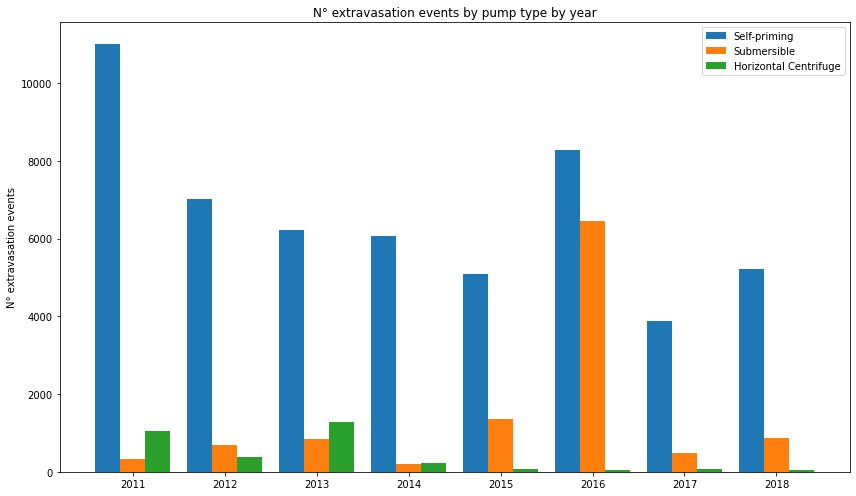

In [0]:

gb = []
for lift_station_index in [25,16,19]:
  alarms = get_alarm_data(lift_station_index)
  #filter by the overflow event
  alarms = alarms[alarms.MESSAGE == 'Limite Alto']
  #count number of events by year
  gb.append(alarms['INTIME_'].groupby([alarms.INTIME_.dt.year]).agg('count'))

#organize datasets to show at plot
labels      = list(gb[0].index.values)
auto        = list(gb[0].values)
subm        = list(gb[1].values)
cent        = list(gb[2].values)

x = np.arange(len(labels))  # the label locations
width = 0.27  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 7))

#create legend with pump type names
rects1 = ax.bar(x, auto, width, label='Self-priming')
rects2 = ax.bar(x + width        , subm, width, label='Submersible')
rects3 = ax.bar(x + 2*width, cent, width, label='Horizontal Centrifuge')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('N° extravasation events')
ax.set_title('N° extravasation events by pump type by year')
ax.set_xticks(x + width)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

**Analysis of sewage overflow events duration by pump type by month**

The plot generated by the code bellow demonstrates a relantionship between sewage overflow duration and the weather station datas. The months with the most total duration has a similarity with the months with the most total precipitation.


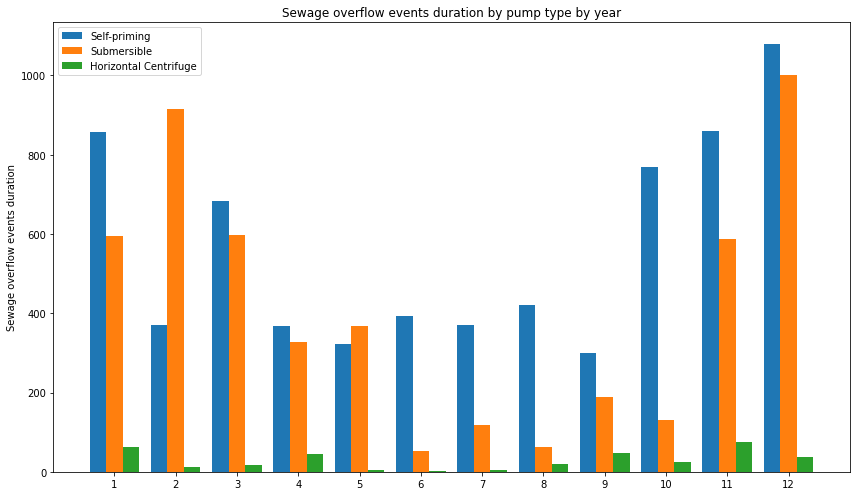

In [0]:
gb = []
for lift_station_index in [25,16,19]:
  alarms = get_alarm_data(lift_station_index)
  #Filter by the overflow event duration between 2012 and 2018
  #The event 'Limite Alto - Normalizado' has both start and event timestamp 
  #filled
  alarms = alarms[(alarms.MESSAGE == 'Limite Alto - Normalizado') & \
                  (alarms.OUTTIME_ > alarms.INTIME_) & \
                  (alarms.INTIME_.dt.year >= 2012) &  \
                  (alarms.INTIME_.dt.year < 2018)]

  #calculates sewage overflow duration
  alarms['overflow_duration'] = ((alarms.OUTTIME_ - alarms.INTIME_)/np.timedelta64(1,'s')) / 3600

  #group the sum of duration by month
  gb.append(alarms['overflow_duration'].groupby([alarms.INTIME_.dt.month]).agg('sum'))

#organize datasets to show at plot
labels      = list(gb[0].index.values)
auto        = list(gb[0].values)
subm        = list(gb[1].values)
cent        = list(gb[2].values)

x = np.arange(len(labels))  # the label locations
width = 0.27  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 7))

#create legend with pump type names
rects1 = ax.bar(x, auto, width, label='Self-priming')
rects2 = ax.bar(x + width        , subm, width, label='Submersible')
rects3 = ax.bar(x + 2*width, cent, width, label='Horizontal Centrifuge')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Sewage overflow events duration')
ax.set_title('Sewage overflow events duration by pump type by year')
ax.set_xticks(x + width)
ax.set_xticklabels(labels)
ax.legend()



fig.tight_layout()

plt.show()

**Get datasets from one specific sewage lift station**

In [0]:
lift_station_index = 15
alarms, instrument_data, eletric_meters, totday = get_datasets(lift_station_index)



**Analysis with level, pumps current and marks from sewage overflow events**

The current signal of the pumps allows extracting information about when the pump is off (current at 0) and information about the time the pumps are on (current greater then 0).

In the graph below, the red marks next to the level graph represent the occurrence of sewage overflow.

In the period presented, it is possible to identify that:
1. The engine current drops during sewage overflow;
2. The pump activation time is longer in the period in which the overflow occurs.

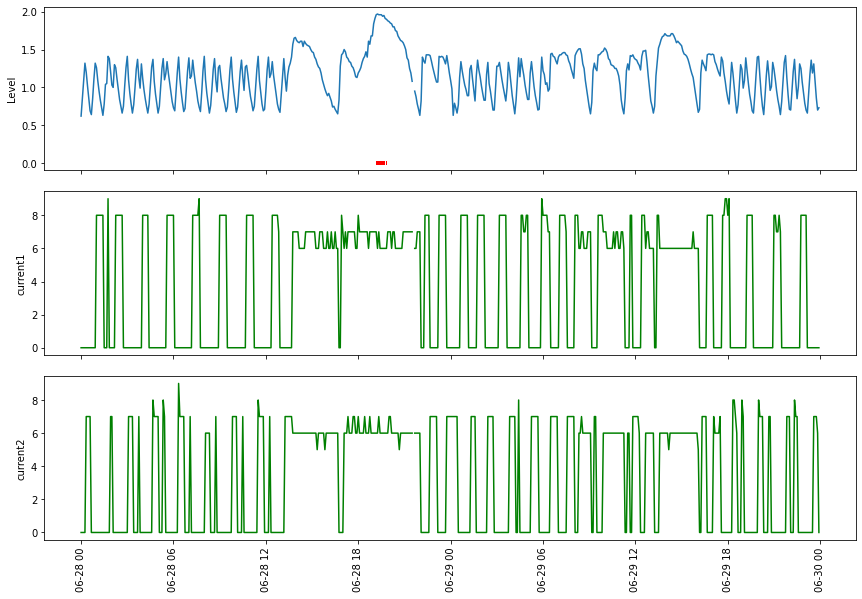

In [0]:
start_datetime  = datetime.datetime(2016,6,28,0,0,0)
end_datetime    = datetime.datetime(2016,6,29,23,59,59)
plot_instument_dat_with_overflow(lift_station_index,
                                 alarms,
                                 instrument_data,  
                                 start_datetime, 
                                 end_datetime)

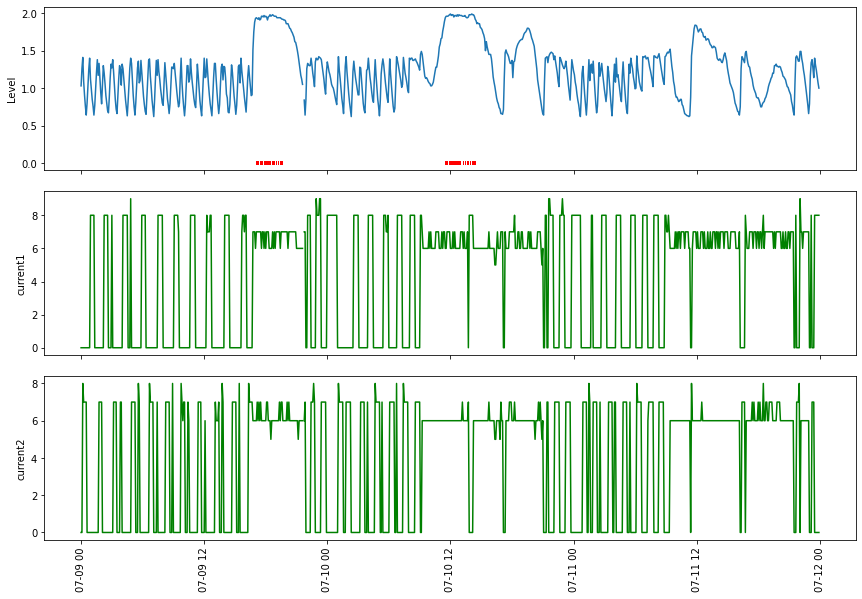

In [0]:
start_datetime  = datetime.datetime(2016,7,9,0,0,0)
end_datetime    = datetime.datetime(2016,7,11,23,59,59)
plot_instument_dat_with_overflow(lift_station_index,
                                 alarms,
                                 instrument_data,  
                                 start_datetime, 
                                 end_datetime)